# Plot map of snow disappearance dates
*J. Michelle Hu  
University of Utah  
August 2024*  
---

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import xarray as xr
from pathlib import PurePath
import datetime

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/work/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# # Set environmental variable for PROJ to directory where you can find proj.db
# os.environ['PROJ']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'
# os.environ['PROJLIB']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'


# Locate pyproj_datadir for studio env
# From https://stackoverflow.com/questions/69630630/on-fresh-conda-installation-of-pyproj-pyproj-unable-to-set-database-path-pypr
CONDA_ENV = 'work'
miniconda_dir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3'
proj_version = h.fn_list(miniconda_dir, f'envs/{CONDA_ENV}/conda-meta/proj-[0-9]*.json')[0]

VERSION = PurePath(proj_version).stem

pyprojdatadir = f'{miniconda_dir}/pkgs/{VERSION}/share/proj'
print(pyprojdatadir)
pyproj.datadir.set_data_dir(pyprojdatadir)

# Set environmental variable for PROJ to directory where you can find proj.db
os.environ['PROJ'] = pyprojdatadir
os.environ['PROJLIB'] = pyprojdatadir
os.environ['PROJ_LIB'] = pyprojdatadir

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj


## Directory

In [4]:
basin = 'animas'
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/'
basindirs = h.fn_list(workdir, f'{basin}*/*/{basin}*/')
wydir = PurePath(basindirs[0]).parents[0].as_posix()

# Get the WY from the directory name
WY = int(PurePath(basindirs[0]).parents[0].stem.split('wy')[-1])
print(WY)

# Use this to thin out the basindirs
basindirs = h.fn_list(workdir, f'{basin}*/*{WY}/{basin}*/')
_ = [print(b) for b in basindirs]

2021
/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/animas_100m_isnobal/wy2021/animas_basin_100m/
/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/animas_100m_isnobal/wy2021/animas_basin_100m_solar_albedo/


## Check for existing files

In [5]:
%%time
# Instantiate empty lists
sdd_date_ds_list = [] # sdd datasets

# Threshold used to calculate SDD
day_thresh = 2

# Flag for running SDD calculations
process_nc = False

for basindir in basindirs:
    try:
        sdd_fn = f'{wydir}/{PurePath(basindir).stem}_sdd_daythresh{day_thresh}.nc'
        print(sdd_fn)
        sdd_date_ds = xr.open_dataset(sdd_fn)
        sdd_date_ds.rio.write_crs("epsg:32613", inplace=True)
        sdd_date_ds_list.append(sdd_date_ds)
    except:
        print(f"{sdd_fn} does not exist, process snow.nc files")
        process_nc = True

/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/animas_100m_isnobal/wy2021/animas_basin_100m_sdd_daythresh2.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/animas_100m_isnobal/wy2021/animas_basin_100m_solar_albedo_sdd_daythresh2.nc
CPU times: user 257 ms, sys: 43.5 ms, total: 301 ms
Wall time: 352 ms


ERROR 1: PROJ: proj_create_from_database: /uufs/chpc.utah.edu/sys/spack/linux-rocky8-nehalem/gcc-8.5.0/proj-8.1.0-usmhdefwvs6hvlo55oavx2t5x6xfarjz/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
ERROR 1: PROJ: proj_create_from_database: /uufs/chpc.utah.edu/sys/spack/linux-rocky8-nehalem/gcc-8.5.0/proj-8.1.0-usmhdefwvs6hvlo55oavx2t5x6xfarjz/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


In [6]:
%%time
if process_nc:
    # list all the daily snow.nc files for a water year for each treatment
    nc_lists = [h.fn_list(basindir, f'*/snow.nc') for basindir in basindirs]
    len(nc_lists)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.2 µs


In [7]:
%%time
if process_nc:
    chunks = 'auto'
    drop_var_list = ['snow_density', 'specific_mass', 'liquid_water', 'temp_surf', 'temp_lower', 'temp_snowcover', 'thickness_lower', 'water_saturation', 'projection']
    thisvar = 'thickness'
    # read in snow depth data
    ds_lists = [[np.squeeze(xr.open_dataset(nc, chunks=chunks, drop_variables=drop_var_list)[thisvar]) for nc in nc_list] for nc_list in nc_lists]
    print(len(ds_lists[0]))

    # Concatenate the list of xarray datasets into a single xarray dataset
    ds_concat_list = [xr.concat(ds_list, dim='time') for ds_list in ds_lists]

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 11.4 µs


In [8]:
%%time
if process_nc:
    import copy
    missing_sdd_dict = dict()

    for basindir, ds in zip(basindirs, ds_concat_list):
        # Create an empty dataset of the same x and y dims to store the SDD values
        sdd_ds = copy.deepcopy(ds.isel(time=0))
        sdd_arr = sdd_ds.data
        print(sdd_arr.shape)

        # Create and empty list for keeping track of missing sdd pixels
        missing_list = []

        # fill the array with the sdd value if calculable
        for i in range(ds.x.size):
            for j in range(ds.y.size):
                try:
                    sdd, _ = proc.calc_sdd(ds[:,j,i].to_series(), day_thresh=day_thresh)
                except:
                    # store the pixel where sdd extraction is an issue
                    print(f"Something wrong with SDD extract for {i, j} at day_thresh of {day_thresh}")
                    missing_list.append((i, j))

                    # add default bogus day to continue
                    sdd = pd.Timestamp(year=WY, month=12, day=25)

                sdd_arr[j, i] = sdd.timestamp()

        # enter the missing_list into a dict using the basindir stems as keys
        missing_sdd_dict[PurePath(basindirs[0]).stem] = missing_list

        sdd_ds.data = sdd_arr

        # Update var name
        sdd_ds.name = 'sdd'

        # remove the time coordinates
        sdd_ds = sdd_ds.drop_vars('time')

        sdd_date_ds = sdd_ds.to_dataset()
        # Convert to datetime to access .dt.dayofyear for DOY calc
        # Needs to be in seconds, put up with nanosecond precision warning
        sdd_date_ds['sdd'] = sdd_date_ds['sdd'].astype('datetime64[s]')

        # Calculate Day of year
        sdd_date_ds['sdd_doy'] = sdd_date_ds['sdd'].dt.dayofyear

        # Clean up attributes
        sdd_date_ds['sdd'].attrs = dict()
        sdd_date_ds['sdd_doy'].attrs = dict()

        # This one's the issue, assigning units in attributions, need to change it to encoding
        # test_ds['sdd'].attrs = dict(units='seconds since 1970-01-01 00:00:00', description='snow disappearance date for each pixel in the domain')
        sdd_date_ds['sdd'].attrs = dict(description='snow disappearance date for each pixel in the domain')
        sdd_date_ds['sdd'].encoding['units'] = "seconds since 1970-01-01 00:00:00"
        sdd_date_ds['sdd_doy'].attrs = dict(units='day of year', description='snow disappearance day of year for each pixel in the domain')

        # write this out
        sdd_date_ds.to_netcdf(f'{wydir}/{PurePath(basindir).stem}_sdd_daythresh{day_thresh}.nc')

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.9 µs


In [9]:
# Should you add another thingy here? 
# # Determine last date at which derivative is nonzero
#     snow_all_gone_date = firstderiv[firstderiv != 0].index[-1]


In [10]:
if process_nc:
    print(missing_sdd_dict.keys())
    import json
    with open(f'{wydir}/missing_sdd_dict_daythresh{day_thresh}.json', 'w') as fp:
        json.dump(missing_sdd_dict, fp)

# Terrain bits

In [11]:
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/isnobal_scripts'
terrain_fns = h.fn_list(script_dir, f'{basin}_setup/data/*100m*.tif')
terrain_fns

['/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/isnobal_scripts/animas_setup/data/animas_32613_100m.tif',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/isnobal_scripts/animas_setup/data/animas_32613_100m_aspect.tif',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/isnobal_scripts/animas_setup/data/animas_32613_100m_hs.tif',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/isnobal_scripts/animas_setup/data/animas_32613_100m_slope.tif']

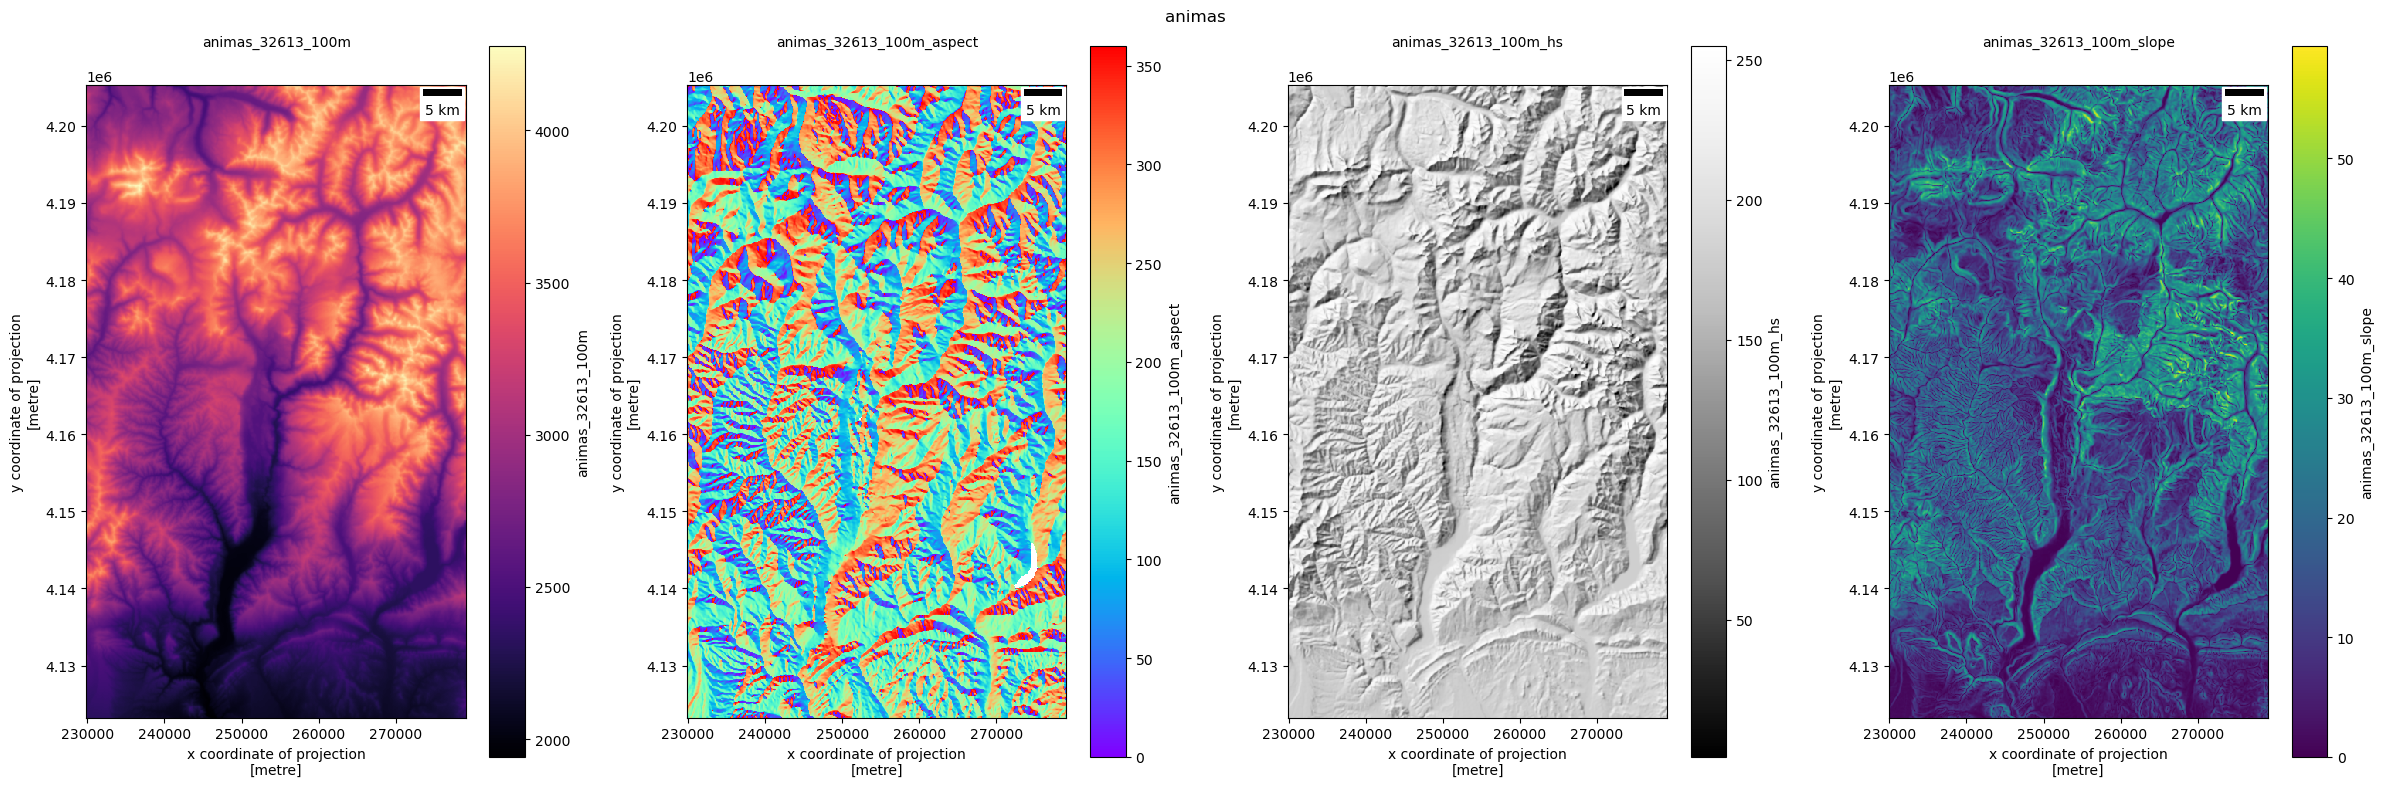

In [12]:
# Load files
terrain_list = [h.load(f) for f in terrain_fns]

# Crop to the same extent as the depth data
cropped_list = [ds.rio.reproject_match(sdd_date_ds['sdd_doy']) for ds in terrain_list]

# Assign individual varnames for ease of use below
dem, aspect, hs, slope = cropped_list

# Plot them up for a quick view
cmaps = ['magma', 'rainbow', 'Greys_r', 'viridis']
terraintitles = [PurePath(f).stem for f in terrain_fns]

fig, axa = plt.subplots(1, len(cropped_list), figsize=(24, 8))
for jdx, ax in enumerate(axa.flatten()):
    h.plot_one(cropped_list[jdx], cmap=cmaps[jdx], specify_ax=(fig, ax), title=terraintitles[jdx])
plt.suptitle(f'{basin}')
plt.tight_layout();

### Plot Snow Disappearance DOY

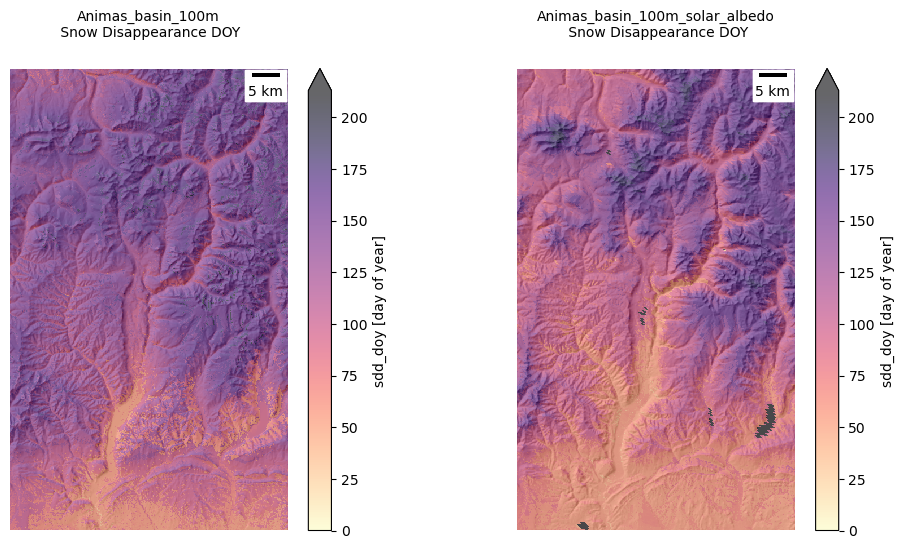

In [13]:
alpha = 0.6
oct1_doy = 274
sep1_doy = 244
aug1_doy = 213

cmap = 'magma_r'
fig, axa = plt.subplots(1, 2, figsize=(12, 6))
for jdx, sdd_date_ds in enumerate(sdd_date_ds_list):
    ax = axa[jdx]
    h.plot_one(hs, cmap='gray', cbaron=False, turnoffframe=True, specify_ax=(fig, ax))
    h.plot_one(sdd_date_ds['sdd_doy'], vmin=0, vmax=aug1_doy, cmap=cmap, 
               title=f'{PurePath(basindirs[jdx]).stem.capitalize()}\n Snow Disappearance DOY', 
               turnoffframe=True, alpha=alpha, specify_ax=(fig, ax))

### Calculate the difference in days between treatments!

In [14]:
# Calculate seconds since up to january first of this water year
elapsed_sec = pd.to_datetime([f'{WY}-01-01 00:00:00']).astype(int) / 10**9
elapsed_sec = int(elapsed_sec[0])

/scratch/local/u6058223/ipykernel_580/1986662815.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([pd.Timestamp((c * 24 * 3600 + elapsed_sec).astype('datetime64[s]')).strftime("%d %b") for c in axa[1].get_xticks()])


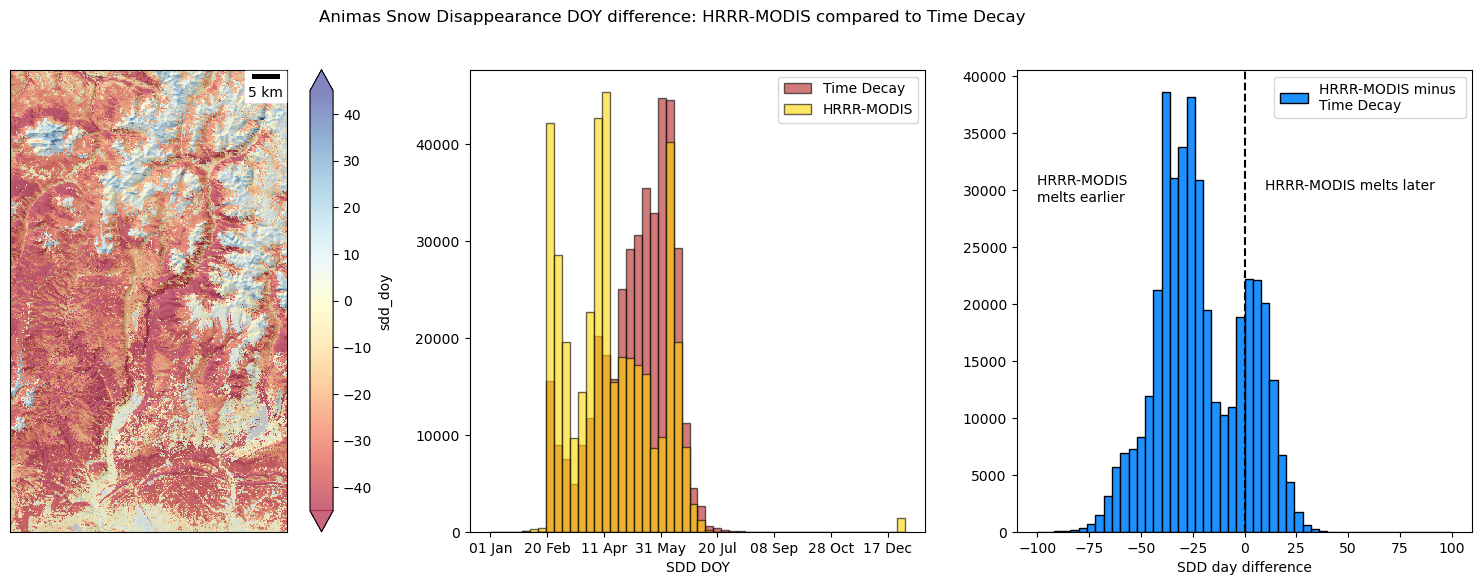

In [15]:
diff_cmap = 'RdYlBu'
title = f'{basin.capitalize()} Snow Disappearance DOY difference: HRRR-MODIS compared to Time Decay'

# Calculate diff in DOY
sdd_diff = proc.calc_doydiff(sdd_date_ds_list, xmas=359, ndv=-9999)
diffval = 45

fig, axa = plt.subplots(1, 3, figsize=(20,6))
ax = axa[0]
h.plot_one(hs, cmap='gray', cbaron=False, 
           turnofflabels=True, turnoffaxes=True,
           alpha=0.8, specify_ax=(fig, ax))

h.plot_one(sdd_diff, vmin=-diffval, vmax=diffval, 
           cmap=diff_cmap, title=None, turnofflabels=True, turnoffaxes=True,
           alpha=0.6, specify_ax=(fig, ax))

# Plot up a histogram of differences
bins = 50
ax = axa[1]
h.plot_hist(sdd_date_ds_list[0]['sdd_doy'], range=(0, 365), specify_ax=(fig, ax), title=None, xlabel='SDD DOY', label='Time Decay', color='firebrick', alpha=alpha, bins=52)
h.plot_hist(sdd_date_ds_list[1]['sdd_doy'], range=(0, 365), specify_ax=(fig, ax), title=None, xlabel='SDD DOY', label='HRRR-MODIS', color='gold', alpha=alpha, bins=52)

# Dates instead of DOY?
# Add seconds since 1970 and convert to seconds for xlabel
ax.set_xticklabels([pd.Timestamp((c * 24 * 3600 + elapsed_sec).astype('datetime64[s]')).strftime("%d %b") for c in axa[1].get_xticks()])
ax.legend()

ax = axa[2]
h.plot_hist(sdd_diff, specify_ax=(fig, ax), range=(-100, 100), title=None, label='HRRR-MODIS minus \nTime Decay', xlabel='SDD day difference', bins=bins)
ax.axvline(x=0, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyle='--', color='k')

# Add some annotation
ax.annotate(text='HRRR-MODIS melts later', xy=(10, 30000))
ax.annotate(text='HRRR-MODIS \nmelts earlier', xy=(-100, 29000))
ax.legend()
plt.suptitle(title);

## Aspect

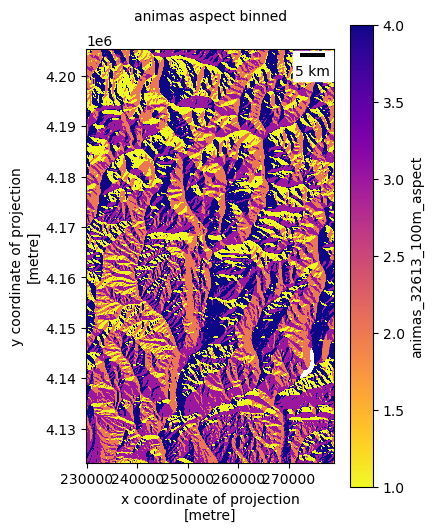

In [16]:
# bin by aspect
aspect_bin = proc.bin_aspect(aspect, basinname=basin)

In [17]:
import seaborn as sns
sns.set_palette('icefire')

In [18]:
# Count up percentages
aspect_proportions = dict()
compass_rose = ['North', 'East', 'South', 'West']
for r in range(4):
    pixelcount = aspect_bin.data[aspect_bin.data==r+1].size
    percent = pixelcount / aspect_bin.size
    print(f"{compass_rose[r]}: {pixelcount} pixels, {percent*100:.1f}% of all pixels")
    aspect_proportions[r+1] = (pixelcount, percent)

North: 78209 pixels, 19.4% of all pixels
East: 100568 pixels, 24.9% of all pixels
South: 112299 pixels, 27.8% of all pixels
West: 111816 pixels, 27.7% of all pixels


North
East
South
West


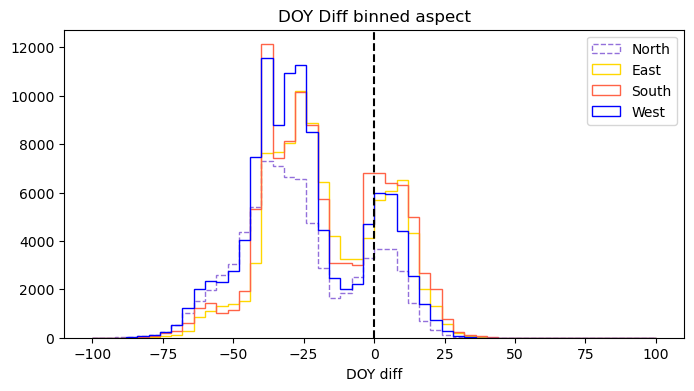

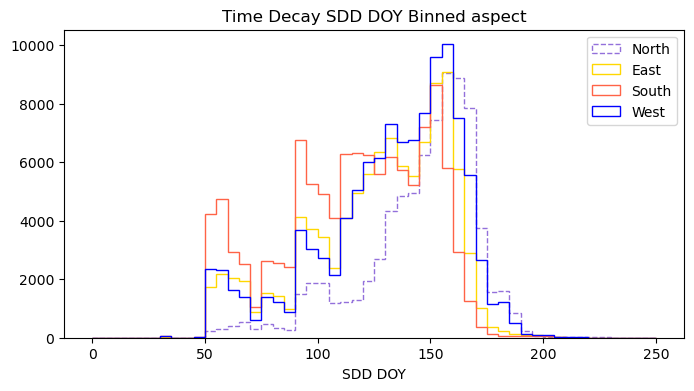

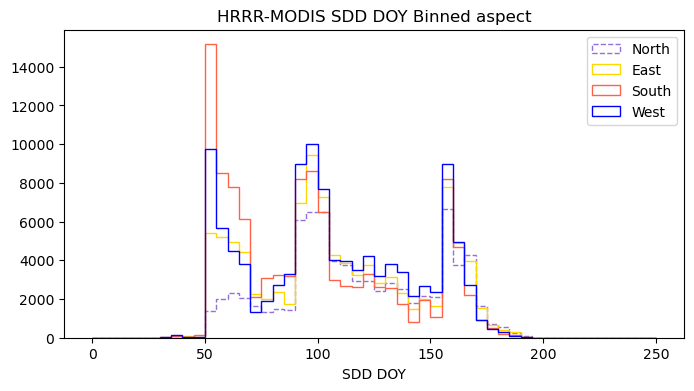

In [19]:
# Loop through array of binned aspect and plot the differences in sdd
figa, axa = plt.subplots(1, figsize=(8,4))
figb, axb = plt.subplots(1, figsize=(8,4))
figc, axc = plt.subplots(1, figsize=(8,4))

# colors = ['dodgerblue', 'gold', 'tomato', 'b', 'teal', 'gray']
# darkcolors = ['royalblue', 'goldenrod', 'darkred', 'midnightblue', 'darkslategray', 'dimgray']
colors = ['mediumpurple', 'gold', 'tomato', 'b', 'teal', 'gray']
darkcolors = ['indigo', 'goldenrod', 'darkred', 'midnightblue', 'darkslategray', 'dimgray']


linestyles = ['--', '-', '-', '-']
for jdx, f in enumerate(np.unique(aspect_bin.data[~np.isnan(aspect_bin.data)])):
    print(compass_rose[jdx])
    data_slice = sdd_diff.data[aspect_bin.data == f]
    h.plot_hist(data_slice, specify_ax=(figa, axa), histtype='step',
                edgecolor=colors[jdx],
                linestyle=linestyles[jdx],
                facecolor=None,
                label=compass_rose[jdx],
                xlabel='DOY diff',
                title='DOY Diff binned aspect', range=(-100, 100), bins=50)

    
    data_slice = sdd_date_ds_list[0]['sdd_doy'].data[aspect_bin.data == f]
    h.plot_hist(data_slice, specify_ax=(figb, axb), histtype='step',
                edgecolor=colors[jdx],
                linestyle=linestyles[jdx],
                facecolor=None,
                label=compass_rose[jdx],
                xlabel='SDD DOY',
                title='Time Decay SDD DOY Binned aspect', range=(0, 250), bins=50)

    data_slice = sdd_date_ds_list[1]['sdd_doy'].data[aspect_bin.data == f]
    h.plot_hist(data_slice, specify_ax=(figc, axc), histtype='step',
                edgecolor=colors[jdx],
                linestyle=linestyles[jdx],
                facecolor=None,
                label=compass_rose[jdx],
                xlabel='SDD DOY',
                title='HRRR-MODIS SDD DOY Binned aspect', range=(0, 250), bins=50)
axa.axvline(x=0, ymin=axa.get_ylim()[0], ymax=axa.get_ylim()[1], linestyle='--', color='k')
for ax in axa, axb, axc:
    ax.legend();

North


NameError: name 'binrange' is not defined

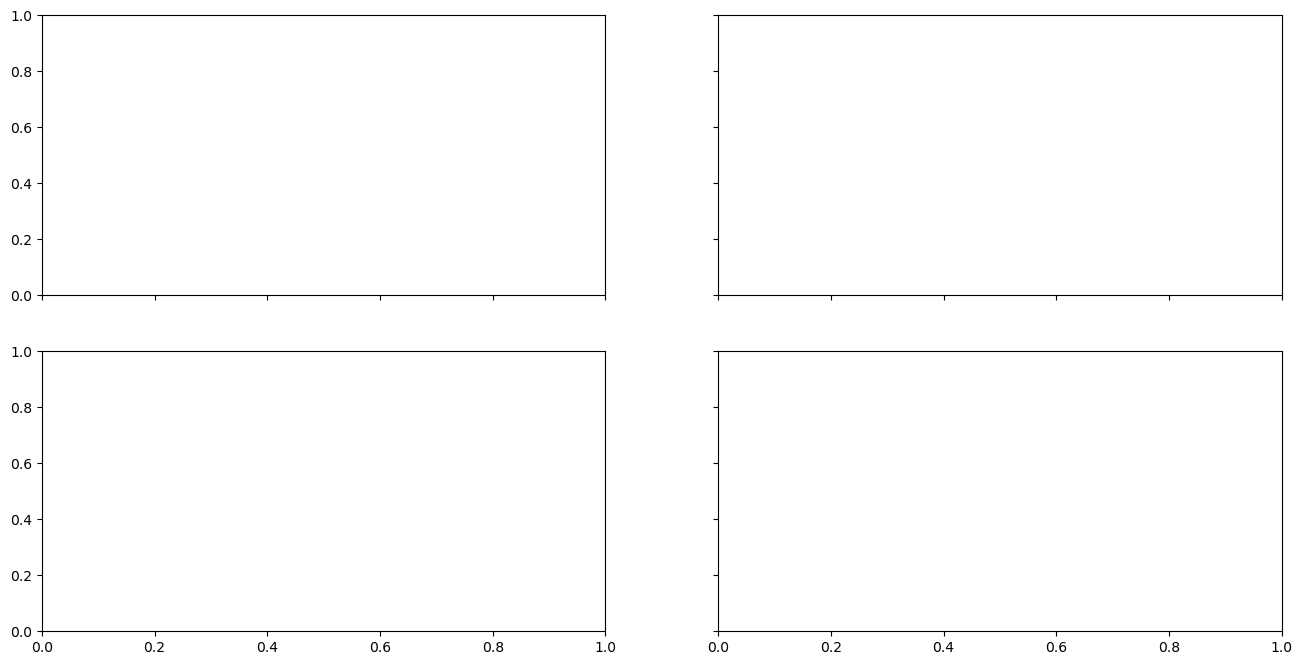

In [20]:
# Loop through array of binned aspect and plot the differences in sdd
fig, axa = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True)
aspect_slices = []
for jdx, f in enumerate(np.unique(aspect_bin.data[~np.isnan(aspect_bin.data)])):
    ax = axa.flatten()[jdx]
    print(compass_rose[jdx])
    data_slice = sdd_date_ds_list[0]['sdd_doy'].data[aspect_bin.data == f]
    ax.annotate(f'Mean [stdev] Time Decay DOY: {np.nanmean(data_slice):.1f} [{np.nanstd(data_slice):.1f}]', xy=(0, 12500), color=darkcolors[jdx], ha='left')
    aspect_slices.append(data_slice)
    h.plot_hist(data_slice, specify_ax=(fig, ax), 
                color=darkcolors[jdx],
                label='Time Decay',
                xlabel='SDD DOY',
                title=compass_rose[jdx], 
                range=binrange, bins=bins)
    data_slice = sdd_date_ds_list[1]['sdd_doy'].data[aspect_bin.data == f]
    ax.annotate(f'Mean [stdev] HRRR-MODIS DOY: {np.nanmean(data_slice):.1f} [{np.nanstd(data_slice):.1f}]', xy=(0, 11000), color=colors[jdx], ha='left')
    aspect_slices.append(data_slice)
    
    h.plot_hist(data_slice, specify_ax=(fig, ax), 
                color=colors[jdx],
                label='HRRR-MODIS',
                xlabel='SDD DOY',
                alpha=alpha,
                title=compass_rose[jdx], 
                range=binrange, bins=bins) 
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.legend();

### Plot by date

In [ ]:
fig, axa = plt.subplots(1, 2, figsize=(12, 6))
for jdx, sdd_date_ds in enumerate(sdd_date_ds_list):
    ax = axa[jdx]
    hs.plot.imshow(cmap='gray', ax=ax, add_colorbar=False)
    s = sdd_date_ds['sdd_doy'].plot.imshow(cmap=cmap, alpha=0.7, ax=ax, vmin=0, vmax=aug1_doy, add_colorbar=False)
    cbar = fig.colorbar(mappable=s, ax=ax)

    # Add seconds since 1970 and convert to seconds
    cbar.set_ticklabels([pd.Timestamp((c * 24 * 3600 + elapsed_sec).astype('datetime64[s]')).strftime("%d %b %Y") for c in cbar.get_ticks()])
    # plt.show()
    ax.set_title(f'{basin.capitalize()}\n Snow Disappearance Date')
    ax.set_aspect('equal');

### Slice by aspect

In [ ]:
# Count up percentages
aspect_proportions = dict()
for r in range(4):
    pixelcount = aspect_bin.data[aspect_bin.data==r+1].size
    percent = pixelcount / aspect_bin.size
    print(f"{compass_rose[r]}: {pixelcount} pixels, {percent*100:.1f}% of all pixels")
    aspect_proportions[r+1] = (pixelcount, percent)

#### This basin has mostly south and west facing slopes, then east facing, and the fewest north-facing slopes

### Average SDD by aspect


In [ ]:
# TODO
# Add standard deviation/other measure of spread around the mean
# Add day range of means - e.g., north vs. south

sdd_date_dict = dict()
print('Mean DOY and snow disappearance dates per binned aspect and treatment')
for basindir, sdd_date_ds in zip(basindirs, sdd_date_ds_list):
    print('\n', PurePath(basindir).stem)
    sdd_date_arr = sdd_date_ds['sdd'].data
    sdd_doy_arr = sdd_date_ds['sdd_doy'].data
    for r in range(4):
        aspect_slice = sdd_date_arr[aspect_bin.data==r+1]
        aspect_doy_slice = sdd_doy_arr[aspect_bin.data==r+1]
        mean_doy = aspect_doy_slice.mean()
        mean_sdd = pd.to_datetime(mean_doy-1, unit='D', origin=pd.Timestamp(f'01-01-{WY}'))
        # print(aspect_slice.min(), aspect_slice.max())
        # print(f'{compass_rose[r]}: {aspect_doy_slice.min()}, {aspect_doy_slice.mean():.1f}, {aspect_doy_slice.max()}')
        print(f'{compass_rose[r]}:\
              {mean_doy:.1f}, {mean_sdd.strftime("%Y-%m-%d")}')
              
        sdd_date_dict[f'{PurePath(basindir).stem}_{r+1}'] = (aspect_slice, aspect_doy_slice)

## Elevation

In [ ]:
dem_bin, dem_elev_ranges = proc.bin_elev(dem, basinname=basin)
print('Mean DOY and snow disappearance dates by elevation and treatment')
dem_elev_ranges

In [ ]:
# bin by elevation range
# store the binned doy values, and mean doy, mean sdd for that bin in a dict

sdd_elev_date_dict = dict()

for basindir, sdd_date_ds in zip(basindirs, sdd_date_ds_list):
    print('\n', PurePath(basindir).stem)
    # sdd_date_arr = sdd_date_ds['sdd'].data
    sdd_doy_arr = sdd_date_ds['sdd_doy'].data
    
    for elev_range in dem_elev_ranges:
        # Extract min and max elevations in that bin
        low, high = dem_elev_ranges[elev_range]
        # sdd_slice = sdd_date_arr[(dem_crop.data>=low) & (dem_crop.data<high)]        
        doy_slice = sdd_doy_arr[(dem.data>=low) & (dem.data<high)]        
        mean_doy = doy_slice.mean()
        mean_sdd = pd.to_datetime(mean_doy-1, unit='D', origin=pd.Timestamp(f'01-01-{WY}'))

        print(f'{low, high}:\
              {mean_doy:.1f}, {mean_sdd.strftime("%Y-%m-%d")}')
              
        # sdd_elev_date_dict[f'{PurePath(basindir).stem}_{low}_{high}'] = (doy_slice, mean_doy, mean_sdd)
        sdd_elev_date_dict[f'{PurePath(basindir).stem}_{low}_{high}'] = (doy_slice, mean_doy, mean_sdd)

In [ ]:
# Plot this up
markerstyles = ['x', 'o']
labels = ['Time Decay', 'HRRR-MODIS']
# labels = [PurePath(basindir).stem for basindir in basindirs]
fig, ax = plt.subplots(1)
for jdx, (basindir, sdd_date_ds) in enumerate(zip(basindirs, sdd_date_ds_list)):
    mean_elevs = []
    mean_doys = []
    for kdx, elev_range in enumerate(dem_elev_ranges):
        low, high = dem_elev_ranges[elev_range]
        mean_elev = (low + high) / 2
        doy_slice, mean_doy, mean_sdd = sdd_elev_date_dict[f'{PurePath(basindir).stem}_{low}_{high}']
        mean_elevs.append(mean_elev)
        mean_doys.append(mean_doy)
        # print(mean_elev)
        # print(mean_doy)
        # ax.scatter(mean_elev, mean_doy, marker=markerstyles[jdx], 
        #            c=sns.color_palette(palette='flare', n_colors=10)[kdx])
    ax.scatter(mean_elevs, mean_doys, marker=markerstyles[jdx], linewidths=1, label=labels[jdx])
    ax.plot(mean_elevs, mean_doys)
# ax.annotate('X - Time decay \n\nO - HRRR-MODIS', xy=(2220, 140))
ax.legend();
ax.set_ylabel('Snow disappearance DOY')
ax.set_xlabel('Binned mean elevation [m]');
ax.set_title(f'{basin.capitalize()}: mean snow disappearance day of year elevation');

In [ ]:
# Plot the paired boxplots by elevation bin
# Plot this up
bval_list = []
colnames = []
for kdx, elev_range in enumerate(dem_elev_ranges):
    for jdx, (basindir, sdd_date_ds) in enumerate(zip(basindirs, sdd_date_ds_list)):
        low, high = dem_elev_ranges[elev_range]
        doy_slice, mean_doy, mean_sdd = sdd_elev_date_dict[f'{PurePath(basindir).stem}_{low}_{high}']
        bvals = proc.extract_boxplot_vals(doy_slice)
        # lowwhisk, p25, p50, p75, highwhisk = proc.extract_boxplot_vals(doy_slice)
        # bvals = lowwhisk, p25, mean_doy, p75, highwhisk
        bval_list.append(bvals)
        colnames.append(f'{PurePath(basindir).stem}_{low}_{high}')


fig, ax = plt.subplots(1, figsize=(12, 6))
df = pd.DataFrame(data=np.array(bval_list).T, columns=colnames)
df.index = ['low_whisk', 'p25', 'p50', 'p75', 'highwhisk']
sns.boxplot(df, palette='icefire_r', ax=ax, width=0.5);
ax.set_xticks(ticks=np.linspace(0.5, 18.5, 10), labels=mean_elevs, rotation=45)
ax.grid(True)
ax.set_ylim(0, 235)
ax.set_xlabel('Binned mean elevation [m]')
ax.set_ylabel('Snow disappearance DOY');

# Annotate with difference between treatments: HRRR-MODIS minus Time Decay
for d, w, e in zip(df.loc['p50'].diff()[1::2], df.loc['highwhisk'][0::2], np.linspace(0.5, 18.5, 10)):
    ax.annotate(text=f'{d} days', xy=(e-0.5, w+15), 
                ha='left',
                bbox=dict(facecolor='white', alpha=1,
                          edgecolor='gray', boxstyle='round, pad=0.2'))
ax.set_title(f'{basin.capitalize()}: difference in median snow disappearance day of year by iSnobal net solar treatment over elevation bins');

## Slope

In [ ]:
slope_bin = proc.bin_slope(slope, basinname=basin)

### Slice by aspect

In [ ]:
# Count up percentages
slope_proportions = dict()
slope_bin_categories = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60']
for r in range(len(np.unique(slope_bin))):
    pixelcount = slope_bin.data[slope_bin.data==r+1].size
    percent = pixelcount / slope_bin.size
    print(f"{slope_bin_categories[r]}: {pixelcount} pixels, {percent*100:.1f}% of all pixels")
    slope_proportions[r+1] = (pixelcount, percent)

h.plot_hist(slope_bin, title=f'{basin.capitalize()} binned slopes', figsize=(4,2), xlabel='Slope bin');

In [ ]:
# Loop through array of binned aspect and plot the differences in sdd
fig, axa = plt.subplots(3, 2, figsize=(16, 12), sharex=True, sharey=True)
slope_slices = []
for jdx, f in enumerate(np.unique(slope_bin.data[~np.isnan(slope_bin.data)])):
    ax = axa.flatten()[jdx]
    print(slope_bin_categories[jdx])
    data_slice = sdd_date_ds_list[0]['sdd_doy'].data[slope_bin.data == f]
    ax.annotate(f'Mean [stdev] Time Decay DOY: {np.nanmean(data_slice):.1f} [{np.nanstd(data_slice):.1f}]', xy=(0, 17750), color=darkcolors[jdx], ha='left')
    slope_slices.append(data_slice)
    h.plot_hist(data_slice, specify_ax=(fig, ax), 
                color=darkcolors[jdx],
                label='Time Decay',
                xlabel='SDD DOY',
                title=slope_bin_categories[jdx], 
                range=binrange, bins=bins)
    data_slice = sdd_date_ds_list[1]['sdd_doy'].data[slope_bin.data == f]
    ax.annotate(f'Mean [stdev] HRRR-MODIS DOY: {np.nanmean(data_slice):.1f} [{np.nanstd(data_slice):.1f}]', xy=(0, 16000), color=colors[jdx], ha='left')
    slope_slices.append(data_slice)
    
    h.plot_hist(data_slice, specify_ax=(fig, ax), 
                color=colors[jdx],
                label='HRRR-MODIS',
                xlabel='SDD DOY',
                alpha=alpha,
                title=slope_bin_categories[jdx], 
                range=binrange, bins=bins) 
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.legend();

In [ ]:
# Plot this up
markerstyles = ['x', 'o']
labels = ['Time Decay', 'HRRR-MODIS']
sdd_slope_date_dict = dict()
fig, ax = plt.subplots(1)
for jdx, (basindir, sdd_date_ds) in enumerate(zip(basindirs, sdd_date_ds_list)):
    sdd_doy_arr = sdd_date_ds['sdd_doy'].data
    mean_slopes = []
    mean_doys = []
    for kdx, slope_range in enumerate(slope_bin_categories):
        low, high = slope_range.split('-')
        low = int(low)
        high = int(high)
        mean_slope = ( low + high ) / 2
        slope_slice = sdd_doy_arr[slope_bin.data==kdx+1]
        mean_doy = slope_slice.mean()
        mean_sdd = pd.to_datetime(mean_doy-1, unit='D', origin=pd.Timestamp(f'01-01-{WY}'))
        
        sdd_slope_date_dict[f'{PurePath(basindir).stem}_{low}_{high}'] = slope_slice, mean_doy, mean_sdd
        
        mean_slopes.append(mean_slope)
        mean_doys.append(mean_doy)
    ax.scatter(mean_slopes, mean_doys, marker=markerstyles[jdx], linewidths=1, label=labels[jdx])
    ax.plot(mean_slopes, mean_doys)
ax.legend();
ax.set_ylabel('Snow disappearance DOY')
ax.set_xlabel('Binned mean slope');
ax.set_title(f'{basin.capitalize()}: mean snow disappearance day of year by slope');

In [ ]:
# Plot the paired boxplots by elevation bin
# Plot this up
bval_list = []
colnames = []
for kdx, slope_range in enumerate(slope_bin_categories):
    for jdx, (basindir, sdd_date_ds) in enumerate(zip(basindirs, sdd_date_ds_list)):
        low, high = slope_range.split('-')
        low = int(low)
        high = int(high)
        doy_slice, mean_doy, mean_sdd = sdd_slope_date_dict[f'{PurePath(basindir).stem}_{low}_{high}']
        bvals = proc.extract_boxplot_vals(doy_slice)
        bval_list.append(bvals)
        colnames.append(f'{PurePath(basindir).stem}_{low}_{high}')


fig, ax = plt.subplots(1, figsize=(12, 6))
df = pd.DataFrame(data=np.array(bval_list).T, columns=colnames)
df.index = ['low_whisk', 'p25', 'p50', 'p75', 'highwhisk']
sns.boxplot(df, palette='icefire_r', ax=ax, width=0.5);

ax.set_xticks(ticks=np.linspace(0.5, 12.5, 7), labels=mean_slopes + ['>60'], rotation=45)
ax.grid(True)
ax.set_ylim(0, 235)
ax.set_xlabel('Binned mean slope [m]')
ax.set_ylabel('Snow disappearance DOY');

# Annotate with difference between treatments: HRRR-MODIS minus Time Decay
for d, w, e in zip(df.loc['p50'].diff()[1::2], df.loc['highwhisk'][0::2], np.linspace(0.5, 12.5, 7)):
    ax.annotate(text=f'{d} days', xy=(e-0.5, w), 
                ha='left',
                bbox=dict(facecolor='white', alpha=1,
                          edgecolor='gray', boxstyle='round, pad=0.2'))
ax.set_title(f'{basin.capitalize()}: difference in median snow disappearance day of year by iSnobal net solar treatment over slope bins');

# Notes
- these are dates where snow is gone, not when snow is beginning to melt
- we can use a similar tactic to determine peak snow depth date which would indicate the earliest point for substantial melt onset
- can we determine a later bound for melt onset depending on the depth decline rate? 
- can we assume that at some point, decreases in depth cannot be due to densification alone and melt must be occurring?